# Turnstile Audio Analysis Visualization
Exploring energy, brightness, and harshness over time

In [60]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import librosa
import librosa.display
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set up nice plotting style
plt.style.use('dark_background')
%matplotlib inline

In [61]:
# Get all available tracks
music_dir = Path('music')
analysis_dir = Path('analysis')

# Find all audio files
audio_files = sorted(list(music_dir.glob('*.m4a')) + list(music_dir.glob('*.mp3')))
track_names = [f.stem for f in audio_files]

# Create dropdown
track_dropdown = widgets.Dropdown(
    options=[(name, i) for i, name in enumerate(track_names)],
    value=0,
    description='Track:',
    style={'description_width': '50px'},
    layout=widgets.Layout(width='400px')
)

display(track_dropdown)
print(f"\nFound {len(track_names)} tracks")

Dropdown(description='Track:', layout=Layout(width='400px'), options=(('01 NEVER ENOUGH', 0), ('02 SOLE', 1), …


Found 14 tracks


In [75]:
# Load selected track's data
selected_idx = track_dropdown.value
track_name = track_names[selected_idx]
audio_file = str(audio_files[selected_idx])
analysis_file = analysis_dir / f"{track_name}_analysis.json"

print(f"Selected: {track_name}")
print(f"Audio: {audio_file}")
print(f"Analysis: {analysis_file}")

# Load analysis JSON
with open(analysis_file, 'r') as f:
    data = json.load(f)

print(f"\nTempo: {data['tempo']:.1f} BPM")
print(f"Duration: {data['duration']:.1f}s ({data['duration']/60:.1f} min)")
print(f"Data points: {len(data['frames']['energy'])}")

Selected: 09 CEILING
Audio: music/09 CEILING.m4a
Analysis: analysis/09 CEILING_analysis.json

Tempo: 123.0 BPM
Duration: 73.0s (1.2 min)
Data points: 3145


# Extract the data
times = np.array(data['frames']['times'])
energy = np.array(data['frames']['energy'])
brightness = np.array(data['frames']['brightness'])
harshness = np.array(data['frames']['harshness'])
beats = np.array(data['beats'])

In [76]:
# Load raw audio
print(f"Loading {audio_file}...")
y, sr = librosa.load(audio_file)
print(f"Sample rate: {sr} Hz")
print(f"Total samples: {len(y):,}")
print(f"Duration: {len(y)/sr:.1f} seconds")

Loading music/09 CEILING.m4a...


/var/folders/xs/qsp6mbzs7k530q9z25kyjg300000gn/T/ipykernel_46215/13376669.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file)


Sample rate: 22050 Hz
Total samples: 1,610,230
Duration: 73.0 seconds


In [77]:
# Load raw audio
print(f"Loading {audio_file}...")
y, sr = librosa.load(audio_file)
print(f"Sample rate: {sr} Hz")
print(f"Total samples: {len(y):,}")
print(f"Duration: {len(y)/sr:.1f} seconds")

Loading music/09 CEILING.m4a...
Sample rate: 22050 Hz
Total samples: 1,610,230
Duration: 73.0 seconds


/var/folders/xs/qsp6mbzs7k530q9z25kyjg300000gn/T/ipykernel_46215/13376669.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file)


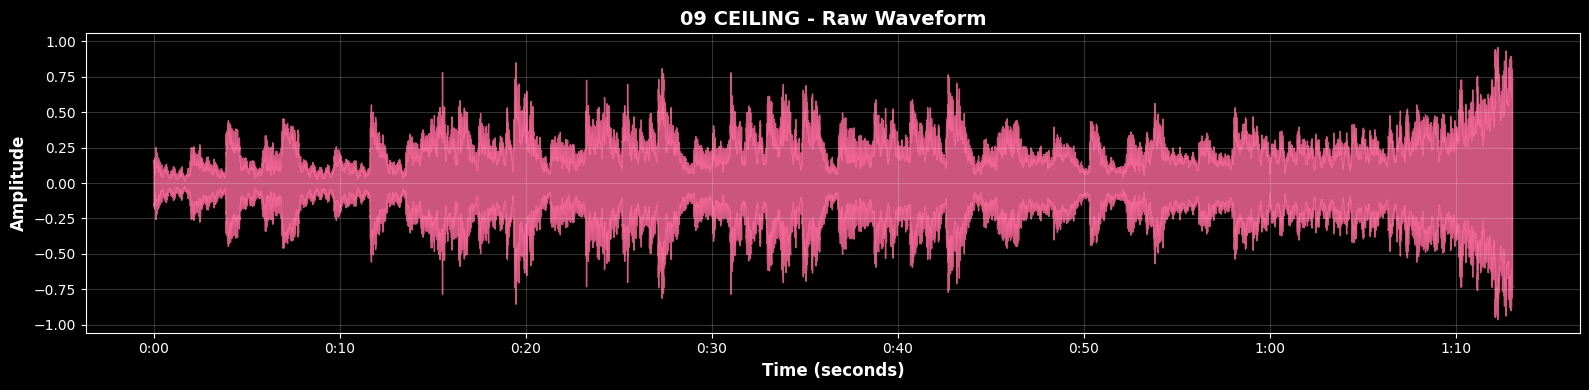

In [78]:
# Plot raw waveform
fig, ax = plt.subplots(figsize=(16, 4))
librosa.display.waveshow(y, sr=sr, ax=ax, color='#ff6b9d', alpha=0.8)
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Amplitude', fontsize=12, fontweight='bold')
ax.set_title(f'{track_name} - Raw Waveform', fontsize=14, fontweight='bold')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Waveform + current analysis metrics side by side
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Raw waveform
librosa.display.waveshow(y, sr=sr, ax=axes[0], color='#ffffff', alpha=0.6)
axes[0].set_ylabel('Raw\nWaveform', fontsize=11, fontweight='bold')
axes[0].set_title(f'{track_name} - Raw Audio vs Extracted Features', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.2)

# Energy (derived from waveform)
axes[1].fill_between(times, energy, alpha=0.7, color='#ff6b9d')
axes[1].plot(times, energy, color='#ff1a75', linewidth=1, alpha=0.8)
axes[1].set_ylabel('Energy\n(RMS)', fontsize=11, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.2)

# Brightness
axes[2].fill_between(times, brightness, alpha=0.7, color='#4ecdc4')
axes[2].plot(times, brightness, color='#1a9991', linewidth=1, alpha=0.8)
axes[2].set_ylabel('Brightness\n(Spectral)', fontsize=11, fontweight='bold')
axes[2].set_ylim(0, 1)
axes[2].grid(alpha=0.2)

# Harshness
axes[3].fill_between(times, harshness, alpha=0.7, color='#ffe66d')
axes[3].plot(times, harshness, color='#ffd23f', linewidth=1, alpha=0.8)
axes[3].set_ylabel('Harshness\n(ZCR)', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[3].set_ylim(0, 1)
axes[3].grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [79]:
# Approach 1: Onset Strength (transient detection)
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
onset_times = librosa.times_like(onset_env, sr=sr)

# Approach 2: Harmonic-Percussive Separation
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Get RMS of each component
rms_total = librosa.feature.rms(y=y)[0]
rms_percussive = librosa.feature.rms(y=y_percussive)[0]
rms_harmonic = librosa.feature.rms(y=y_harmonic)[0]
rms_times = librosa.times_like(rms_total, sr=sr)

# Percussion ratio (how much of the signal is percussive)
# Add small epsilon to avoid division by zero
percussion_ratio = rms_percussive / (rms_total + 1e-8)

print("Harmonic-Percussive separation complete!")
print(f"Average percussion ratio: {np.mean(percussion_ratio):.2%}")

Harmonic-Percussive separation complete!
Average percussion ratio: 10.92%


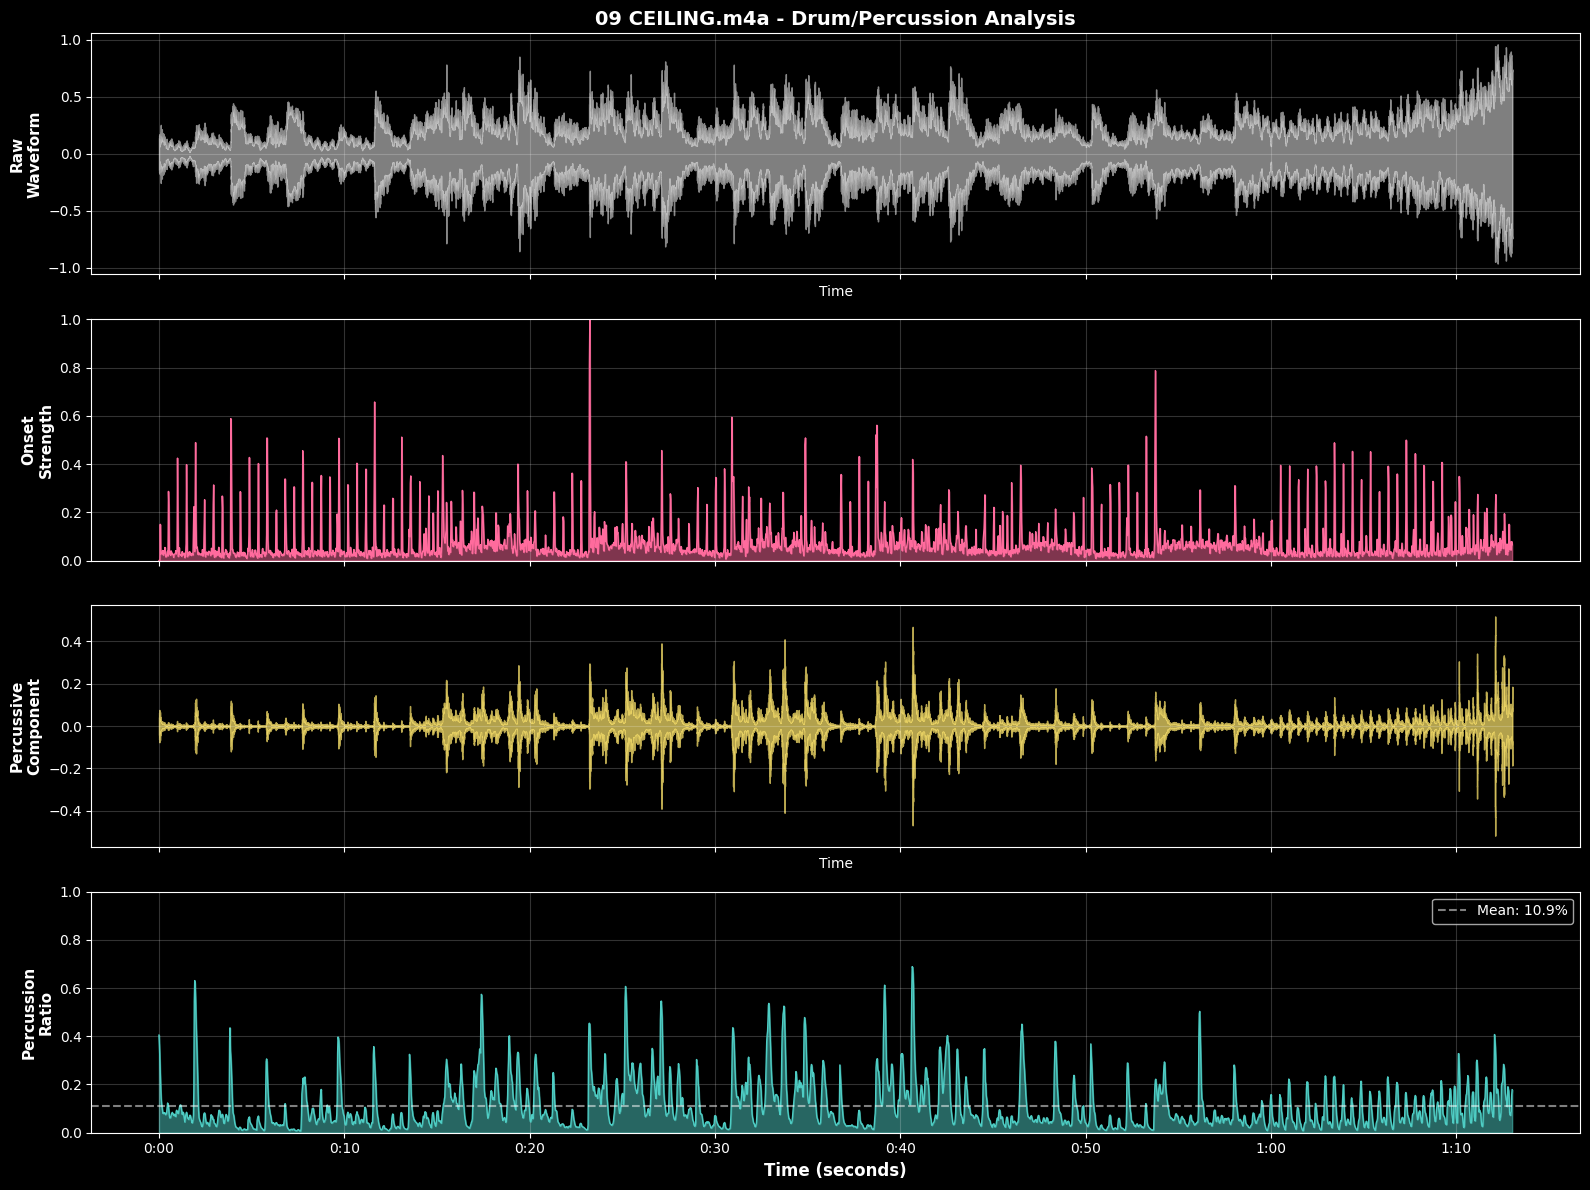

In [80]:
# Visualize drum detection approaches
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Raw waveform for reference
librosa.display.waveshow(y, sr=sr, ax=axes[0], color='#ffffff', alpha=0.5)
axes[0].set_ylabel('Raw\nWaveform', fontsize=11, fontweight='bold')
axes[0].set_title(f'{data["filename"]} - Drum/Percussion Analysis', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.2)

# Onset strength (transient detection)
axes[1].plot(onset_times, onset_env / onset_env.max(), color='#ff6b9d', linewidth=1)
axes[1].fill_between(onset_times, onset_env / onset_env.max(), alpha=0.5, color='#ff6b9d')
axes[1].set_ylabel('Onset\nStrength', fontsize=11, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.2)

# Percussive component waveform
librosa.display.waveshow(y_percussive, sr=sr, ax=axes[2], color='#ffe66d', alpha=0.7)
axes[2].set_ylabel('Percussive\nComponent', fontsize=11, fontweight='bold')
axes[2].grid(alpha=0.2)

# Percussion ratio over time
axes[3].plot(rms_times, percussion_ratio, color='#4ecdc4', linewidth=1)
axes[3].fill_between(rms_times, percussion_ratio, alpha=0.5, color='#4ecdc4')
axes[3].set_ylabel('Percussion\nRatio', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[3].set_ylim(0, 1)
axes[3].axhline(np.mean(percussion_ratio), color='white', linestyle='--', alpha=0.5, 
                label=f'Mean: {np.mean(percussion_ratio):.1%}')
axes[3].legend()
axes[3].grid(alpha=0.2)

plt.tight_layout()
plt.show()

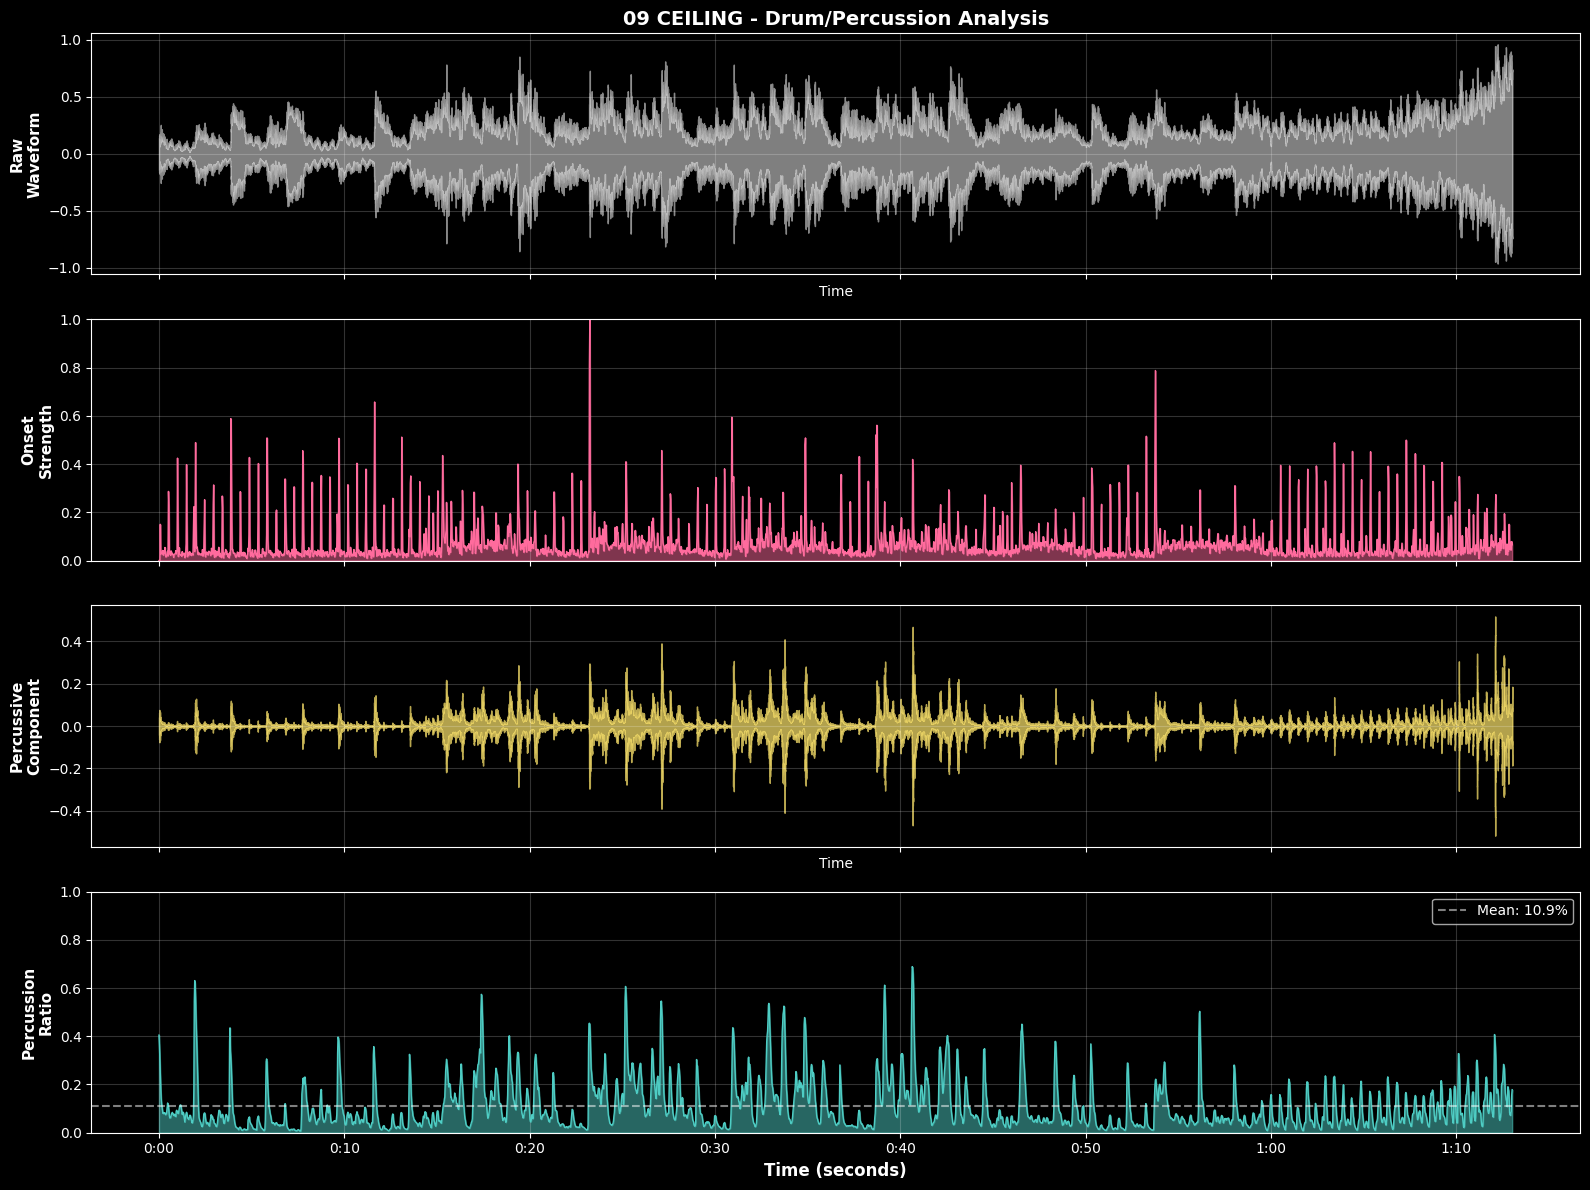

In [81]:
# Visualize drum detection approaches
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Raw waveform for reference
librosa.display.waveshow(y, sr=sr, ax=axes[0], color='#ffffff', alpha=0.5)
axes[0].set_ylabel('Raw\nWaveform', fontsize=11, fontweight='bold')
axes[0].set_title(f'{track_name} - Drum/Percussion Analysis', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.2)

# Onset strength (transient detection)
axes[1].plot(onset_times, onset_env / onset_env.max(), color='#ff6b9d', linewidth=1)
axes[1].fill_between(onset_times, onset_env / onset_env.max(), alpha=0.5, color='#ff6b9d')
axes[1].set_ylabel('Onset\nStrength', fontsize=11, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.2)

# Percussive component waveform
librosa.display.waveshow(y_percussive, sr=sr, ax=axes[2], color='#ffe66d', alpha=0.7)
axes[2].set_ylabel('Percussive\nComponent', fontsize=11, fontweight='bold')
axes[2].grid(alpha=0.2)

# Percussion ratio over time
axes[3].plot(rms_times, percussion_ratio, color='#4ecdc4', linewidth=1)
axes[3].fill_between(rms_times, percussion_ratio, alpha=0.5, color='#4ecdc4')
axes[3].set_ylabel('Percussion\nRatio', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[3].set_ylim(0, 1)
axes[3].axhline(np.mean(percussion_ratio), color='white', linestyle='--', alpha=0.5, 
                label=f'Mean: {np.mean(percussion_ratio):.1%}')
axes[3].legend()
axes[3].grid(alpha=0.2)

plt.tight_layout()
plt.show()

# Listen to the separated components (if you want to verify)
# Uncomment to save the percussive-only track:

# import soundfile as sf
# sf.write(f'{track_name}_percussive.wav', y_percussive, sr)
# sf.write(f'{track_name}_harmonic.wav', y_harmonic, sr)
# print("Saved separated audio files!")

# For now just show stats
print("=== Percussion Analysis Summary ===")
print(f"Track: {track_name}")
print(f"Average percussion ratio: {np.mean(percussion_ratio):.1%}")
print(f"Max percussion ratio: {np.max(percussion_ratio):.1%}")
print(f"Sections with >50% percussion: {np.mean(percussion_ratio > 0.5):.1%} of track")

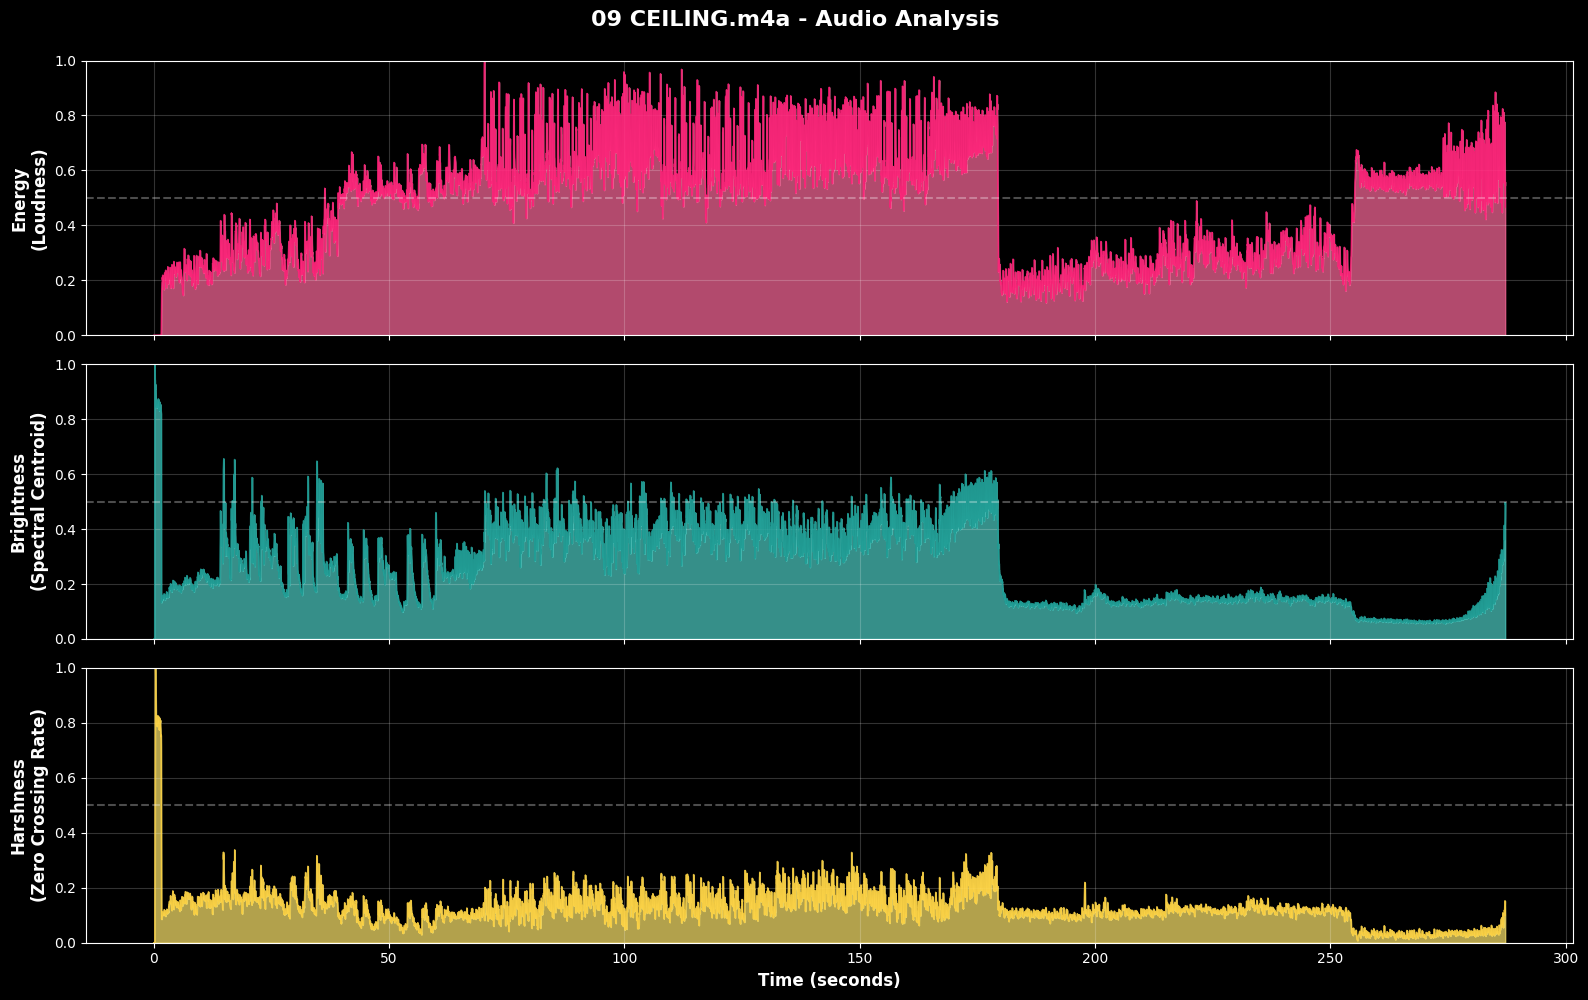

In [82]:
# Plot all three metrics
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Energy
axes[0].fill_between(times, energy, alpha=0.7, color='#ff6b9d', label='Energy')
axes[0].plot(times, energy, color='#ff1a75', linewidth=1, alpha=0.8)
axes[0].set_ylabel('Energy\n(Loudness)', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(alpha=0.2)
axes[0].axhline(0.5, color='white', linestyle='--', alpha=0.3)

# Brightness
axes[1].fill_between(times, brightness, alpha=0.7, color='#4ecdc4', label='Brightness')
axes[1].plot(times, brightness, color='#1a9991', linewidth=1, alpha=0.8)
axes[1].set_ylabel('Brightness\n(Spectral Centroid)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.2)
axes[1].axhline(0.5, color='white', linestyle='--', alpha=0.3)

# Harshness
axes[2].fill_between(times, harshness, alpha=0.7, color='#ffe66d', label='Harshness')
axes[2].plot(times, harshness, color='#ffd23f', linewidth=1, alpha=0.8)
axes[2].set_ylabel('Harshness\n(Zero Crossing Rate)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[2].set_ylim(0, 1)
axes[2].grid(alpha=0.2)
axes[2].axhline(0.5, color='white', linestyle='--', alpha=0.3)

plt.suptitle(f'{data["filename"]} - Audio Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Plot all three metrics
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Energy
axes[0].fill_between(times, energy, alpha=0.7, color='#ff6b9d', label='Energy')
axes[0].plot(times, energy, color='#ff1a75', linewidth=1, alpha=0.8)
axes[0].set_ylabel('Energy\n(Loudness)', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(alpha=0.2)
axes[0].axhline(0.5, color='white', linestyle='--', alpha=0.3)

# Brightness
axes[1].fill_between(times, brightness, alpha=0.7, color='#4ecdc4', label='Brightness')
axes[1].plot(times, brightness, color='#1a9991', linewidth=1, alpha=0.8)
axes[1].set_ylabel('Brightness\n(Spectral Centroid)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.2)
axes[1].axhline(0.5, color='white', linestyle='--', alpha=0.3)

# Harshness
axes[2].fill_between(times, harshness, alpha=0.7, color='#ffe66d', label='Harshness')
axes[2].plot(times, harshness, color='#ffd23f', linewidth=1, alpha=0.8)
axes[2].set_ylabel('Harshness\n(Zero Crossing Rate)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[2].set_ylim(0, 1)
axes[2].grid(alpha=0.2)
axes[2].axhline(0.5, color='white', linestyle='--', alpha=0.3)

plt.suptitle(f'{track_name} - Audio Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

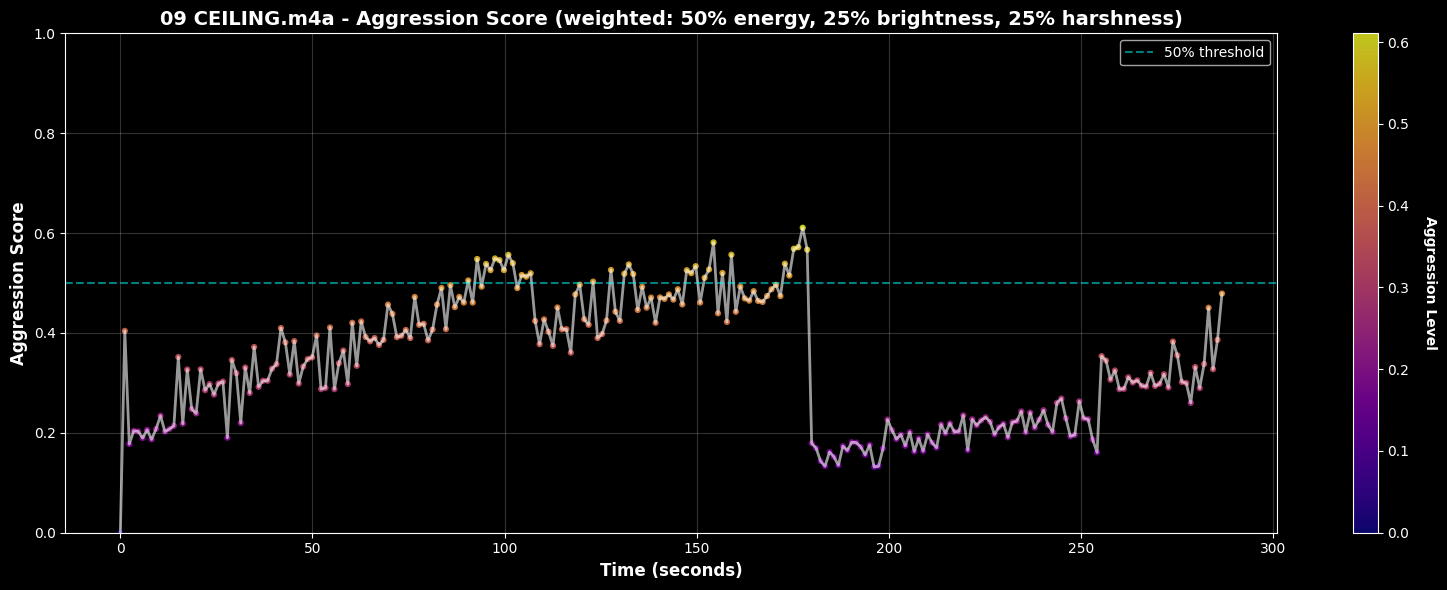

Plotted 248 points (downsampled from 12367 for performance)


In [83]:
# Create a combined "aggression" metric
# Higher energy + higher brightness + higher harshness = more aggressive
aggression = (energy * 0.5) + (brightness * 0.25) + (harshness * 0.25)

# OPTIMIZED: Downsample for plotting (much faster!)
downsample = 50  # Plot every 50th point
times_plot = times[::downsample]
aggression_plot = aggression[::downsample]

fig, ax = plt.subplots(figsize=(16, 6))

# Use scatter with colormap instead of individual fills
points = ax.scatter(times_plot, aggression_plot, 
                   c=aggression_plot, cmap='plasma', 
                   s=20, alpha=0.8, edgecolors='none')

# Add line plot
ax.plot(times_plot, aggression_plot, color='white', linewidth=2, alpha=0.6)

# Add colorbar to show the gradient scale
cbar = plt.colorbar(points, ax=ax)
cbar.set_label('Aggression Level', rotation=270, labelpad=20, fontweight='bold')

ax.set_ylabel('Aggression Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(alpha=0.2)

# Add threshold line
ax.axhline(0.5, color='cyan', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend()

plt.title(f'{data["filename"]} - Aggression Score (weighted: 50% energy, 25% brightness, 25% harshness)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Plotted {len(times_plot)} points (downsampled from {len(times)} for performance)")

# Create a combined "aggression" metric
# Higher energy + higher brightness + higher harshness = more aggressive
aggression = (energy * 0.5) + (brightness * 0.25) + (harshness * 0.25)

# OPTIMIZED: Downsample for plotting (much faster!)
downsample = 50  # Plot every 50th point
times_plot = times[::downsample]
aggression_plot = aggression[::downsample]

fig, ax = plt.subplots(figsize=(16, 6))

# Use scatter with colormap instead of individual fills
points = ax.scatter(times_plot, aggression_plot, 
                   c=aggression_plot, cmap='plasma', 
                   s=20, alpha=0.8, edgecolors='none')

# Add line plot
ax.plot(times_plot, aggression_plot, color='white', linewidth=2, alpha=0.6)

# Add colorbar to show the gradient scale
cbar = plt.colorbar(points, ax=ax)
cbar.set_label('Aggression Level', rotation=270, labelpad=20, fontweight='bold')

ax.set_ylabel('Aggression Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(alpha=0.2)

# Add threshold line
ax.axhline(0.5, color='cyan', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend()

plt.title(f'{track_name} - Aggression Score (weighted: 50% energy, 25% brightness, 25% harshness)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Plotted {len(times_plot)} points (downsampled from {len(times)} for performance)")

Track Analysis:
  Aggressive: 13.1% of track
  Calm/Vibes: 86.9% of track

For text displacement:
  First 13.1% → aggressive shader
  Last 86.9% → ethereal shader


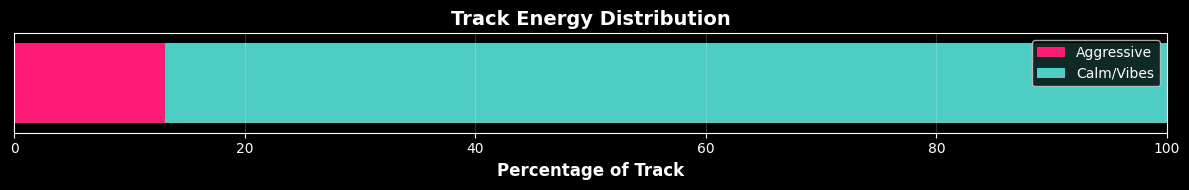

In [84]:
# Calculate what percentage of the track is "aggressive" (above threshold)
threshold = 0.5
aggressive_frames = np.sum(aggression > threshold)
total_frames = len(aggression)
aggressive_percentage = (aggressive_frames / total_frames) * 100

print(f"Track Analysis:")
print(f"  Aggressive: {aggressive_percentage:.1f}% of track")
print(f"  Calm/Vibes: {100-aggressive_percentage:.1f}% of track")
print(f"\nFor text displacement:")
print(f"  First {aggressive_percentage:.1f}% → aggressive shader")
print(f"  Last {100-aggressive_percentage:.1f}% → ethereal shader")

# Visualize the split
fig, ax = plt.subplots(figsize=(12, 2))
ax.barh([0], [aggressive_percentage], color='#ff1a75', label='Aggressive')
ax.barh([0], [100-aggressive_percentage], left=[aggressive_percentage], 
        color='#4ecdc4', label='Calm/Vibes')
ax.set_xlim(0, 100)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Percentage of Track', fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.legend(loc='upper right')
ax.grid(axis='x', alpha=0.2)
plt.title('Track Energy Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Timeline View - Finding Transitions

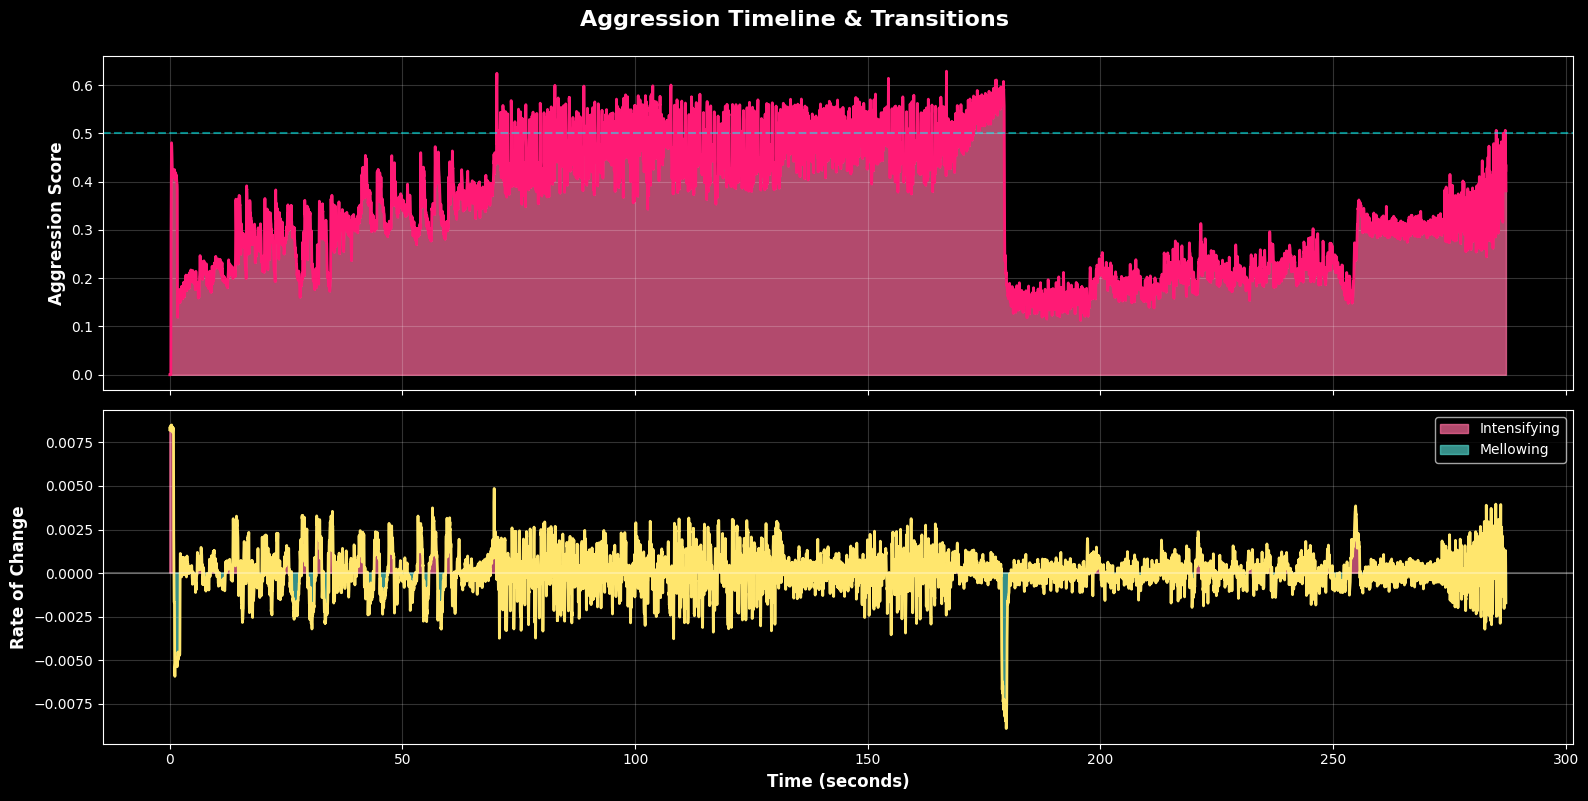

In [85]:
# Find major transitions in aggression (for interesting shader breakpoints)
# Calculate rate of change
aggression_diff = np.diff(aggression)
window_size = 50  # Smooth it out
aggression_diff_smooth = np.convolve(aggression_diff, np.ones(window_size)/window_size, mode='same')

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Top: aggression score
axes[0].fill_between(times, aggression, alpha=0.7, color='#ff6b9d')
axes[0].plot(times, aggression, color='#ff1a75', linewidth=2)
axes[0].set_ylabel('Aggression Score', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.2)
axes[0].axhline(0.5, color='cyan', linestyle='--', alpha=0.5)

# Bottom: rate of change (transitions)
axes[1].plot(times[:-1], aggression_diff_smooth, color='#ffe66d', linewidth=2)
axes[1].axhline(0, color='white', linestyle='-', alpha=0.3)
axes[1].fill_between(times[:-1], 0, aggression_diff_smooth, 
                     where=aggression_diff_smooth>0, alpha=0.7, color='#ff6b9d', label='Intensifying')
axes[1].fill_between(times[:-1], 0, aggression_diff_smooth, 
                     where=aggression_diff_smooth<0, alpha=0.7, color='#4ecdc4', label='Mellowing')
axes[1].set_ylabel('Rate of Change', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.2)
axes[1].legend()

plt.suptitle('Aggression Timeline & Transitions', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Export simplified data for p5.js

In [86]:
# Downsample for p5.js (we don't need 12k points for real-time visuals)
downsample_factor = 10  # Keep every 10th point

p5_data = {
    'filename': data['filename'],
    'tempo': data['tempo'],
    'duration': data['duration'],
    'frames': {
        'times': times[::downsample_factor].tolist(),
        'energy': energy[::downsample_factor].tolist(),
        'brightness': brightness[::downsample_factor].tolist(),
        'harshness': harshness[::downsample_factor].tolist(),
        'aggression': aggression[::downsample_factor].tolist()
    },
    'beats': beats.tolist(),
    'stats': {
        'aggressive_percentage': float(aggressive_percentage),
        'calm_percentage': float(100 - aggressive_percentage)
    }
}

output_file = '01 NEVER ENOUGH_p5.json'
with open(output_file, 'w') as f:
    json.dump(p5_data, f, indent=2)

print(f"Exported {len(p5_data['frames']['times'])} points to {output_file}")
print(f"(downsampled from {len(times)} points)")

Exported 1237 points to 01 NEVER ENOUGH_p5.json
(downsampled from 12367 points)


In [87]:
# Downsample for p5.js (we don't need 12k points for real-time visuals)
downsample_factor = 10  # Keep every 10th point

p5_data = {
    'filename': track_name,
    'tempo': data['tempo'],
    'duration': data['duration'],
    'frames': {
        'times': times[::downsample_factor].tolist(),
        'energy': energy[::downsample_factor].tolist(),
        'brightness': brightness[::downsample_factor].tolist(),
        'harshness': harshness[::downsample_factor].tolist(),
        'aggression': aggression[::downsample_factor].tolist()
    },
    'beats': beats.tolist(),
    'stats': {
        'aggressive_percentage': float(aggressive_percentage),
        'calm_percentage': float(100 - aggressive_percentage)
    }
}

output_file = f'{track_name}_p5.json'
with open(output_file, 'w') as f:
    json.dump(p5_data, f, indent=2)

print(f"Exported {len(p5_data['frames']['times'])} points to {output_file}")
print(f"(downsampled from {len(times)} points)")

Exported 1237 points to 09 CEILING_p5.json
(downsampled from 12367 points)


In [ ]:
.